In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras_tuner
from keras_tuner.tuners import RandomSearch
import numpy as np
import statistics

import re
from keras.preprocessing.text import one_hot, Tokenizer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
import tensorflow
from io import StringIO
import pandas as pd
import numpy as np 
import keras
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from numpy import array
from keras.preprocessing.text import one_hot, Tokenizer 
from keras.utils import pad_sequences 
from keras.models import Sequential, Model
from keras.layers import Flatten, Input, Concatenate, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, GRU, MultiHeadAttention, Add, Bidirectional,  Activation, Dropout, Dense, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import seaborn as sns
import nltk
from numpy import asarray
from numpy import zeros
from keras.layers import Conv1D
from keras.layers import LSTM
import json
from keras.optimizers import Adam
from tensorflow.keras.utils import serialize_keras_object
from tensorflow.keras import utils
from tensorflow.keras.models import clone_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
import joblib
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score
lemmatizer = WordNetLemmatizer()
text_tokenizer = nltk.RegexpTokenizer(r"\w+")

stop_words = set(stopwords.words('english'))
from nltk.corpus import wordnet



In [2]:
from keras.utils import plot_model
import pydotplus
from IPython.display import Image
import netron
import torch
from torchviz import make_dot

In [3]:
# Optimize the use of space during training 
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [4]:
def preprocess_sentence(text_):

    # Remove links, mentions     
    # reduce all text to lower case
    text_ = text_.lower()

    #Remove mentions
    text_ = re.sub('@\S+', ' ', text_)
    
    #Remove any links
    text_ = re.sub('https?:\S+|http?:\S', ' ', text_)
    
    # Remove puntuations and numbers
    text_ = re.sub('[^a-zA-Z]', ' ', text_)

    # Single character removal 
    text_ = re.sub(r"\s+[a-zA-z]\s+", ' ', text_)

    # Remove multiple spaces
    text_ = re.sub(r'\s+', ' ', text_)

    return text_


def Xtrain_pre_processing(x_feature):
    feature = []
    text_ = list(x_feature)
    for txt in text_:
        sent = preprocess_sentence(txt)
#         sent = clean_text(txt)
        
#         extr_con_val = extract_concept_value_pairs(sent)
        feature.append(sent)
    return feature


In [5]:
import pickle
import os

# Define the file path where the tokenizer was saved
file_path = 'Tokenizers\\tokenizer_bi_att_1.pkl'

# Load the tokenizer from the specified file path
with open(file_path, 'rb') as tokenizer_file:
    loaded_tokenizer = pickle.load(tokenizer_file)

# Now, `loaded_tokenizer` contains the tokenizer that you saved

In [6]:
#  This function prepares the embedding layer for our NN, it takes in the feature input and returns a tokenized array with padding 
def prep_embedding_layer(feature_, posit_of_padd_, max_padd_len, tokenizer_):


    feature_ = tokenizer_.texts_to_sequences(feature_)

    feature_ = pad_sequences(feature_, padding=posit_of_padd_, maxlen=max_padd_len, truncating='post')
    
    return feature_

In [7]:
def live_test_model(_model, padding_, _text, tokenizer_):
    """
    This function takes an input text, preprocesses it, and uses the provided model and tokenizer
    to predict the probabilities of each class for the input text.

    Args:
        _model (tensorflow.keras.models.Model): The pre-trained model for prediction.
        padding_ (str): Padding type for text preprocessing ('post' or 'pre').
        _text (str): The input text to be predicted.
        tokenizer_ (Tokenizer): The Tokenizer used for text preprocessing.

    Returns:
        list: A list of formatted probabilities for each class.
    """
    X_live_test = Xtrain_pre_processing([_text])
#     print(X_live_test)
    X_live_test = prep_embedding_layer(X_live_test, 'post', padding_, tokenizer_)
#     print(X_live_test)
#     print(X_live_test.shape)
    yhat = _model.predict(X_live_test)
    
    predicted_probabilities = yhat[0]

    # Format and print the probabilities
    formatted_probabilities = [float("{:.6f}".format(prob)) for prob in predicted_probabilities]
#     formatted_probabilities = formatted_probabilities.as
    return formatted_probabilities

In [8]:
def get_key_by_value(dictionary, value):
    """
    Get a dictionary key by its corresponding value.

    Args:
        dictionary (dict): The dictionary to search.
        value: The value to search for.

    Returns:
        Key: The key in the dictionary associated with the given value.

    Example:
        my_dict = {'apple': 1, 'banana': 2, 'cherry': 3}
        key = get_key_by_value(my_dict, 2)
        print(key)  # Output: 'banana'
        
    """
    for key, val in dictionary.items():
        if val == value:
            return key
        
label_interp = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}

In [9]:
def test_full_articel(_sentences, model_, padding_, tokenizer_):


    article_sentiment= []

    for sentence in _sentences:
        results = live_test_model(model_, max_length_, sentence, tokenizer_)
        article_sentiment.append(results)
    
    sent_pred = np.argmax(article_sentiment, axis=1)
    sent_pred
    sentiment_averages = [sum(col) / len(col) for col in zip(*article_sentiment)]

    # ////////////////////// Calculate median ///////////////////////////////
    # Transpose the data (swap rows and columns) for easier column-wise processing
    transposed_data = list(map(list, zip(*article_sentiment)))

    # Calculate the median for each column
    sentiment_medians = [statistics.median(col) for col in transposed_data]

    # sentiment_medians now contains the median of each column
    # Print the list of sentences
    for i, sentence in enumerate(_sentences, 1):
        print(f"Sentence {i} {get_key_by_value(label_interp, sent_pred[i-1])} : {sentence}\n")
    print(f'Average: {sentiment_averages}')
    print(f'Median: {sentiment_medians}')
    print(np.unique(sent_pred, return_counts=True))
    return sentiment_medians, sentiment_averages

In [10]:
class MyAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        # Initialize the layer with the specified number of units
        super(MyAttention, self).__init__()
        self.units = units

        # Define three dense layers for weight calculations
        self.dense1 = tf.keras.layers.Dense(units)
        self.dense2 = tf.keras.layers.Dense(units)
        self.dense3 = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # Expand the dimensions of the hidden state
        hidden_timeA = tf.expand_dims(hidden, 1)

        # Calculate the attention score using tanh activation
        score = tf.nn.tanh(self.dense1(features) + self.dense2(hidden_timeA))

        # Apply softmax to obtain attention weights
        att_weights = tf.nn.softmax(self.dense3(score), axis=1)

        # Calculate the context vector by element-wise multiplication
        contxt_vector = att_weights * features
        # Sum the context vector along axis 1
        contxt_vector = tf.reduce_sum(contxt_vector, axis=1)

        # Return the context vector and attention weights
        return contxt_vector, att_weights
    
    # Allowing for easier loading when loading the NN model
    def get_config(self):
        config = super(MyAttention, self).get_config()
        config.update({'units': self.units})
        return config

        

    


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

custom_objects = {
    'f1_m': f1_m,
    'precision_m':precision_m,
    'recall_m': recall_m,
    'MyAttention': MyAttention
}

# Path to the saved model
model_path = 'Model/Saved_Hyp_Bi_ATT_2_model'

# Load the saved model
loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

In [11]:
loaded_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding_7 (Embedding)     (None, 300, 300)             3965400   ['input_8[0][0]']             
                                                                                                  
 bidirectional_20 (Bidirect  (None, 300, 320)             590080    ['embedding_7[0][0]']         
 ional)                                                                                           
                                                                                                  
 bidirectional_21 (Bidirect  (None, 300, 320)             590080    ['embedding_7[0][0]']   

In [343]:
model_path_11 = 'Model/Saved_Hyp_Bi_ATT_2_model/saved_model.pb'
netron.start(model_path_11)

Serving 'Model/Saved_Hyp_Bi_ATT_2_model/saved_model.pb' at http://localhost:8080


('localhost', 8080)

In [12]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.13.0


In [13]:
relative_path = 'Dataset\\fin_news_optimized_6.csv'
fin_news_1 = pd.read_csv(relative_path)

<AxesSubplot:xlabel='labels', ylabel='count'>

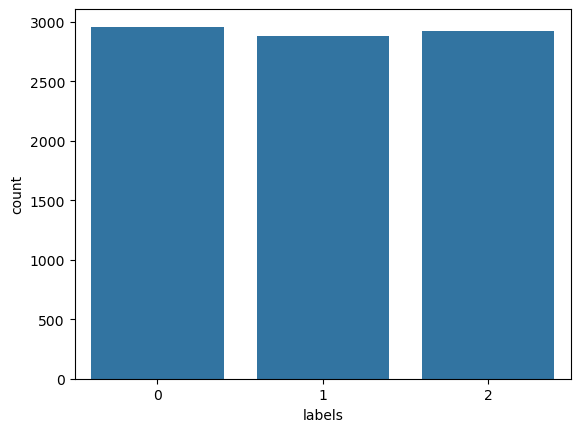

In [80]:
sns.countplot(x='labels', data=fin_news_1)

In [81]:
fin_news_1

,sentence,labels
0,"according to gran , the company has no plans t...",1
1,technopolis plans to develop in stages an area...,1
2,the international electronic industry company ...,0
3,with the new production plant the company woul...,2
4,according to the company 's updated strategy f...,2
...,...,...
8756,surpassed analysts estimated earnings per share,2
8757,surpassing estimated EPS,2
8758,for the 4-months period through to the end of ...,2
8759,"coming to the end of this quarter, company has...",2


In [14]:
X = Xtrain_pre_processing(fin_news_1['sentence'])
fin_news_1['labels'] = fin_news_1['labels'].astype(int)
y = fin_news_1['labels']

In [15]:
max_length_ = 300

In [16]:
X0_train, X0_test, y0_train, y0_test =  train_test_split(X, y, test_size = 0.25, random_state = 42)

In [17]:
X0_train_emb = prep_embedding_layer(X0_train, 'post', max_length_, loaded_tokenizer)
X0_test_emb = prep_embedding_layer(X0_test, 'post', max_length_, loaded_tokenizer)
y0_train_OHE =  tensorflow.keras.utils.to_categorical(y0_train, num_classes=3)
y0_test_OHE =  tensorflow.keras.utils.to_categorical(y0_test, num_classes=3)

In [18]:
len(X0_test_emb)

2191

In [19]:
loaded_model.evaluate(X0_test_emb,y0_test_OHE, batch_size=16 )

137/137 [==============================] - 75s 518ms/step - loss: 0.4624 - acc: 0.8288 - AUC: 0.9485 - f1_m: 0.8299 - precision_m: 0.8368 - recall_m: 0.8234


[0.46237820386886597,
 0.8288452625274658,
 0.9485046863555908,
 0.829851508140564,
 0.836828887462616,
 0.8234184980392456]

## Backtest Data 

In [20]:
shel_q1_2022 = pd.read_csv('shel_Q1_2022_EPS_News.csv')
shel_q2_2022 = pd.read_csv('shel_Q2_2022_EPS_News.csv')
shel_q3_2022 = pd.read_csv('shel_Q3_2022_EPS_News.csv')
shel_q4_2022 = pd.read_csv('shel_Q4_2022_EPS_News.csv')
shel_q1_2023 = pd.read_csv('shel_Q1_2023_EPS_News.csv')
shel_q2_2023 = pd.read_csv('shel_Q2_2023_EPS_News.csv')

In [46]:
bp_q1_2022 = pd.read_csv('bp_Q1_2022_EPS_News.csv')
bp_q2_2022 = pd.read_csv('bp_Q2_2022_EPS_News.csv')
bp_q3_2022 = pd.read_csv('bp_Q3_2022_EPS_News.csv')
bp_q4_2022 = pd.read_csv('bp_Q4_2022_EPS_News.csv')
bp_q1_2023 = pd.read_csv('bp_Q1_2023_EPS_News.csv')
# bp_q2_2023 = pd.read_csv('bp_Q2_2023_EPS_News.csv')

In [22]:
max(bp_q1_2022['Date'])

'2022-05-03T11:31:03-04:00'

In [29]:
shel_q1_2022_title = shel_q1_2022[['Headline']]
shel_q1_2022_article = shel_q1_2022[['Article']]

In [47]:
bp_q1_2022_title = bp_q1_2022[['Headline']]
bp_q1_2022_article = bp_q1_2022[['Article']]

In [48]:
bp_q1_2022_article['Article']

0    BP on Tuesday reported bumper first-quarter pr...
1    BP Plc boosted its share buybacks by $2.5 bill...
2    BP plc BP has reported first-quarter 2022 adju...
3    LONDON, May 3 (Reuters) - BP (BP.L), opens new...
Name: Article, dtype: object

In [30]:
shel_q1_2022_title

,Headline
0,Oil giant Shell reports highest quarterly prof...
1,Shell posts record quarterly profit of $9 billion
2,"Shell (SHEL) Q1 Earnings Beat on Oil Price, Bu..."


In [31]:
bp_q1_2022_title

,Headline
0,"BP reports bumper first-quarter net profit, bu..."
1,BP Expands Buybacks After ‘Exceptional’ Tradin...
2,"BP Beats Q1 Earnings Estimates, Announces Shar..."


In [32]:
shel_q1_2022_article

,Article
0,\nOil giant Shell\n on Thursday reported its ...
1,Shell on Thursday reported a record first-quar...
2,Europe’s largest oil company Shell plc SHEL r...


In [33]:
bp_q1_2022_article

,Article
0,BP on Tuesday reported bumper first-quarter pr...
1,BP Plc boosted its share buybacks by $2.5 bill...
2,BP plc BP has reported first-quarter 2022 adju...


In [34]:
shel_q1_2022_title['Headline'][0]

'Oil giant Shell reports highest quarterly profit since 2008 on soaring commodity prices'

In [35]:
bp_q1_2022_title['Headline'][0]

'BP reports bumper first-quarter net profit, but posts massive loss on hit from Russia exit'

## SHEL Q1 2022

In [140]:
article = shel_q1_2022_article['Article'][0]
sentences = nltk.sent_tokenize(article)
test_full_articel(sentences, loaded_model, max_length_, loaded_tokenizer)
# Good results

Sentence 1:  
Oil giant Shell
 on Thursday reported its highest quarterly profit since 2008 on soaring commodity prices, fueling calls for a one-off windfall tax on oil and gas companies to help U.K. households with spiraling energy bills.

Sentence 2: Shell posted adjusted earnings of $9.1 billion for the three months through to the end of March, in line with expectations of analysts polled by Refinitiv.

Sentence 3: That compared with $3.2 billion over the same period a year earlier and $6.4 billion for the fourth quarter of 2021.

Sentence 4: The company also announced plans to increase its dividend by around 4% to $0.25 per share for the first quarter.

Sentence 5: Of the firm’s $8.5 billion share buyback program announced for the first half of the year, Shell said $4 billion had been completed to date.

Sentence 6: The remaining $4.5 billion share buybacks are scheduled to be completed before the announcement of second-quarter earnings.

Sentence 7: Shares of the company rose 3% o

1/1 [==============================] - 0s 94ms/step
['of the firm billion share buyback program announced for the first half of the year shell said billion had been completed to date ']
[[   2    1  285   82   47 6792  411  189    6    1   39  240    2    1
    29 1102   24   82  149   57  713    4 1034    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0 

1/1 [==============================] - 0s 103ms/step
['france totalenergies norway equinor and s oil giants chevron and exxon mobil also reported strong first quarter profits on soaring commodity prices ']
[[ 508  836    5   63  115 3700 6585    5 2535 9122   50  237  324   39
    46 1348    7 4515   91    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
  

1/1 [==============================] - 0s 99ms/step
[' the impacts of this uncertainty and the higher cost that comes with it are being felt far and wide ']
[[   1 4757    2   41 3902    5    1   73  362   22 1038   14   21   34
   350 4890  642    5 1316    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0

[0.40038781249999994, 0.3377848124999999, 0.2618273125]

In [141]:
article = shel_q1_2022_article['Article'][1]
sentences = nltk.sent_tokenize(article)
test_full_articel(sentences, loaded_model, max_length_, loaded_tokenizer)
# Good results

Sentence 1: Shell on Thursday reported a record first-quarter profit of $9.13 billion, boosted by higher oil and gas prices, stellar refining profits and the strong performance of its trading division.

Sentence 2: The last of the energy majors to report results, Shell joins sector rivals, including BP (BP) and TotalEnergies (TOT) in making big profits from the commodity price volatility stoked by Russia’s invasion of Ukraine that began on Feb. 24.

Sentence 3: It beat its previous highest quarterly profits recorded in 2008 even after writing down $3.9 billion post-tax as a result of its decision to exit operations in Russia.

Sentence 4: It is also winding down oil and gas trading with Russia.

Sentence 5: Shell’s shares rose 3.3% in early trading, outperforming the 1.8% rise of an index of oil and gas companies.

Sentence 6: By the end of this year, Shell said it would stop all of its long-term Russian crude oil purchases, except two contracts with a “small, independent Russian produ

1/1 [==============================] - 0s 119ms/step
['shell shares rose in early trading outperforming the rise of an index of oil and gas companies ']
[[1102   53  173    3  767  371    1  217    2   27  454    2  115    5
   366   79    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    

1/1 [==============================] - 0s 105ms/step
['the european union chief executive on wednesday proposed phased oil embargo on russia that if backed by member states would be watershed for the world largest trading bloc given its dependence on russian fuel although the bloc has yet to work on gas ban ']
[[   1  386 1031  421  607    7  494 1002 8619  115    7  160   22  289
  1822   17 1016  398   99   20    6    1   93  225  371 8862 1598   19
     7  249  700 3277    1 8862   18 1776    4  472    7  366  677    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    

[0.2867277, 0.2093051, 0.503967]

In [142]:
article = shel_q1_2022_article['Article'][2]
sentences = nltk.sent_tokenize(article)
test_full_articel(sentences, loaded_model, max_length_, loaded_tokenizer)
# Good results

Sentence 1:  Europe’s largest oil company Shell plc SHEL reported first-quarter earnings per ADS (on a current cost of supplies basis, excluding items — the market’s preferred measure) — of $2.38.

Sentence 2: The bottom line came in above the Zacks Consensus Estimate of $2.12 and surged from the year-earlier quarter’s earnings of 82 cents per ADS, backed by stronger commodity prices.

Sentence 3: Shell’s revenues of $83.2 billion were up significantly from first-quarter 2021 sales of $59.1 billion.

Sentence 4: Meanwhile, Shell repurchased $3.5 billion of shares in the first quarter.

Sentence 5: The energy group also announced that it has already brought back shares worth $4 billion of the total $8.5 billion scheduled for the first half of 2022.

Sentence 6: The remaining $4.5 billion will be completed before SHEL comes out with second-quarter earnings.

Sentence 7: On another positive note, Shell boosted its quarterly dividend by some 4% to 25 cents per share.

[' europe largest oil

[0.10804257142857142, 0.3349105714285714, 0.5570467142857144]

In [372]:
article = shel_q1_2022_article['Article'][2]
sentences = nltk.sent_tokenize(article)
test_full_articel(sentences, loaded_model, max_length_, loaded_tokenizer)
# Good results

1/1 [==============================] - 0s 318ms/step
Sentence 1 POSITIVE :  Europe’s largest oil company Shell plc SHEL reported first-quarter earnings per ADS (on a current cost of supplies basis, excluding items — the market’s preferred measure) — of $2.38.

Sentence 2 POSITIVE : The bottom line came in above the Zacks Consensus Estimate of $2.12 and surged from the year-earlier quarter’s earnings of 82 cents per ADS, backed by stronger commodity prices.

Sentence 3 POSITIVE : Shell’s revenues of $83.2 billion were up significantly from first-quarter 2021 sales of $59.1 billion.

Sentence 4 NEUTRAL : Meanwhile, Shell repurchased $3.5 billion of shares in the first quarter.

Sentence 5 NEUTRAL : The energy group also announced that it has already brought back shares worth $4 billion of the total $8.5 billion scheduled for the first half of 2022.

Sentence 6 NEUTRAL : The remaining $4.5 billion will be completed before SHEL comes out with second-quarter earnings.

Sentence 7 POSITIVE :

([0.030489, 0.038537, 0.717021],
 [0.10804257142857142, 0.3349105714285714, 0.5570467142857144])

## BP Q1 2022

In [39]:
bp_q1_2022_article

,Article
0,BP on Tuesday reported bumper first-quarter pr...
1,BP Plc boosted its share buybacks by $2.5 bill...
2,BP plc BP has reported first-quarter 2022 adju...


In [38]:
article = bp_q1_2022_article['Article'][0]
sentences = nltk.sent_tokenize(article)
test_full_articel(sentences, loaded_model, max_length_, loaded_tokenizer)
# Good results

1/1 [==============================] - 0s 95ms/step
Sentence 1 POSITIVE : BP on Tuesday reported bumper first-quarter profits and boosted share buybacks, despite posting a massive loss after offloading its nearly-20% stake in Russian-controlled oil company Rosneft.

Sentence 2 POSITIVE : The oil and gas giant’s first-quarter underlying replacement cost profit, used as a proxy for net profit, jumped to its highest level in more than a decade as it came in at $6.2 billion.

Sentence 3 POSITIVE : That compared with a profit of $4.1 billion in the fourth quarter and $2.6 billion for the first quarter of 2021.

Sentence 4 NEUTRAL : Analysts had expected BP to report first-quarter profit of $4.5 billion, according to Refinitiv.

Sentence 5 NEUTRAL : The oil and gas giant also announced a further $2.5 billion in share buybacks.

Sentence 6 POSITIVE : However, BP reported a headline loss for the quarter of $20.4 billion.

Sentence 7 NEUTRAL : This included non-cash pre-tax charges of $24 billi

([0.04976, 0.27905250000000004, 0.461214],
 [0.125247, 0.37273124999999996, 0.5020217499999999])

In [40]:
article = bp_q1_2022_article['Article'][1]
sentences = nltk.sent_tokenize(article)
test_full_articel(sentences, loaded_model, max_length_, loaded_tokenizer)
# Good results

1/1 [==============================] - 0s 89ms/step
Sentence 1 POSITIVE : BP Plc boosted its share buybacks by $2.5 billion as cash flow surged, offsetting some of the discomfort caused by a $25.5 billion charge linked to its planned exit from Russia.

Sentence 2 POSITIVE : The company comfortably surpassed analysts’ expectations after an “exceptional” first quarter for its oil and gas trading business.

Sentence 3 NEGATIVE : Other commodities traders from Bunge Ltd. to Glencore Plc have also posted stronger profits, aided by the unprecedented volatility caused by the war.

Sentence 4 POSITIVE : Shares of BP rose 1.9% to 393.8 pence as of 8:04 a.m. in London.

Sentence 5 NEGATIVE : “In a quarter dominated by the tragic events in Ukraine and volatility in energy markets, BP’s focus has been on supplying the reliable energy our customers need,” Chief Executive Officer Bernard Looney said in a statement on Tuesday.

Sentence 6 NEUTRAL : “Our decision in February to exit our shareholding i

([0.068829, 0.169019, 0.586888],
 [0.18993063157894738, 0.23163205263157896, 0.578437105263158])

In [42]:
article = bp_q1_2022_article['Article'][2]
sentences = nltk.sent_tokenize(article)
test_full_articel(sentences, loaded_model, max_length_, loaded_tokenizer)
# Good results

1/1 [==============================] - 0s 118ms/step
Sentence 1 NEGATIVE : BP plc BP has reported first-quarter 2022 adjusted earnings of $1.92 per American Depositary Share (“ADS”) on a replacement-cost basis, excluding non-operating items.

Sentence 2 POSITIVE : The bottom line beat the Zacks Consensus Estimate of earnings of $1.41 per share and also rose from 78 cents reported a year ago.

Sentence 3 NEGATIVE : Total quarterly revenues of $51,220 million missed the Zacks Consensus Estimate of $53,134 million.

Sentence 4 POSITIVE : However, the top line increased from $36,492 million in the year-ago quarter.

Sentence 5 POSITIVE : The strong quarterly earnings were driven by higher realizations of commodity prices.

Sentence 6 NEGATIVE : BP p.l.c.

Sentence 7 NEGATIVE : price-consensus-eps-surprise-chart | BP p.l.c.

Sentence 8 NEUTRAL : Quote

Share Repurchases
BP announced plans to execute a $2.5-billion share buyback, which is expected to complete before reporting the second-quar

([0.040415, 0.03792, 0.632912],
 [0.19208527659574465, 0.29031712765957446, 0.517597595744681])

In [50]:
article = bp_q1_2022_article['Article'][3]
sentences = nltk.sent_tokenize(article)
test_full_articel(sentences, loaded_model, max_length_, loaded_tokenizer)
# Good results

1/1 [==============================] - 0s 90ms/step
Sentence 1 POSITIVE : LONDON, May 3 (Reuters) - BP (BP.L), opens new tab reported its strongest operational performance in more than a decade on Tuesday on the back of rocketing oil prices that helped it step up share buybacks, even as a $24 billion writedown from exiting Russia led to a record quarterly loss.

Sentence 2 POSITIVE : Shares in the energy firm climbed 2.8% by 1311 GMT in London trading after BP reported its highest operational profit since 2008, encouraging more calls for a windfall tax to help British households and other consumers cope with spiralling fuel bills.

Sentence 3 POSITIVE : Advertisement · Scroll to continue

Report this ad
Soaring oil and gas prices in the wake of the Russian invasion of Ukraine on Feb. 24 helped offset losses BP incurred from abruptly abandoning its shareholdings in Russia, including its 19.75% stake in oil giant Rosneft (ROSN.MM), opens new tab.

Sentence 4 NEGATIVE : read more
The non-

([0.07517299999999999, 0.1748005, 0.26297550000000003],
 [0.23846716666666667, 0.3613254000000001, 0.40020749999999994])

## SHEL Q2 2022

In [146]:
shel_q2_2022

,Date,Time_Zone,Headline,Article,Quarter,Year
0,2022-07-28T08:00:00-04:00,EDT,Shell smashes record again with $11.5 bln profit,Shell (SHEL.L) posted record results on Thurs...,2,2022
1,2022-07-28T08:00:00-04:00,EDT,"Shell Posts Back-to-Back Record Profit, Accele...",Shell Plc accelerated share buybacks after re...,2,2022
2,2022-07-28T08:00:00-04:00,EDT,Shell’s Q2 adjusted earnings more than double ...,Shell has reported a more than two-fold increa...,2,2022


In [145]:
article = shel_q2_2022['Article'][0]
sentences = nltk.sent_tokenize(article)
test_full_articel(sentences, loaded_model, max_length_, loaded_tokenizer)

Sentence 1:  Shell (SHEL.L) posted record results on Thursday, with a $11.5 billion second-quarter profit smashing the mark it set only three months ago, lifted by strong gas trading and a tripling of refining profit.

Sentence 2: The company also announced a $6 billion share buyback programme for the current quarter but did not raise its dividend of 25 cents per share.

Sentence 3: It said shareholder returns would remain "in excess of 30% of cash flow from operating activities".

Sentence 4: A rapid recovery in demand after the end of pandemic lockdowns and a surge in energy prices, driven by Russia's invasion of Ukraine, have boosted profits for energy companies after a two-year slump.

Sentence 5: Shell bought back $8.5 billion of shares in the first half of 2022 and the new programme is significantly higher than forecast.

Sentence 6: "The strong oil price backdrop has helped Shell deliver a blockbuster set of results.

Sentence 7: The dividend may have remained the same, but the 

1/1 [==============================] - 0s 83ms/step
['shell bought back billion of shares in the first half of and the new programme is significantly higher than forecast ']
[[ 1102   588   164    82     2    53     3     1    39   240     2     5
      1    36 10232     9  2426    73    67   857     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     

1/1 [==============================] - 0s 116ms/step
['its oil and gas production in the second quarter was down from the previous quarter at million barrels of oil equivalent per day boepd ']
[[  19  115    5  366  106    3    1  118   46   31   74   10    1  646
    46   15   30 8415    2  115 4348   92  128    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    

1/1 [==============================] - 0s 96ms/step
Sentence 1 POSITIVE :  Shell (SHEL.L) posted record results on Thursday, with a $11.5 billion second-quarter profit smashing the mark it set only three months ago, lifted by strong gas trading and a tripling of refining profit.

Sentence 2 NEUTRAL : The company also announced a $6 billion share buyback programme for the current quarter but did not raise its dividend of 25 cents per share.

Sentence 3 NEUTRAL : It said shareholder returns would remain "in excess of 30% of cash flow from operating activities".

Sentence 4 POSITIVE : A rapid recovery in demand after the end of pandemic lockdowns and a surge in energy prices, driven by Russia's invasion of Ukraine, have boosted profits for energy companies after a two-year slump.

Sentence 5 POSITIVE : Shell bought back $8.5 billion of shares in the first half of 2022 and the new programme is significantly higher than forecast.

Sentence 6 POSITIVE : "The strong oil price backdrop has hel

[0.31480142857142857, 0.19997242857142855, 0.4852262857142856]

In [148]:
article = shel_q2_2022['Article'][1]
sentences = nltk.sent_tokenize(article)
test_full_articel(sentences, loaded_model, max_length_, loaded_tokenizer)

Sentence 1:  Shell Plc accelerated share buybacks after reporting record profit for a second consecutive quarter due to high oil and gas prices.

Sentence 2: The company will repurchase a further $6 billion of shares in the third quarter, having already bought back $8.5 billion of stock in the first half of the year.

Sentence 3: It’s the latest sign of how Russia’s invasion of Ukraine has delivered a windfall for investors in major energy producers, even as the soaring costs of fuel batters the economy and threatens a cost-of-living crisis.

Sentence 4: Almost every major European oil company to report second-quarter earnings so far, from Norway’s Equinor ASA to France’s TotalEnergies SE and Spain’s Repsol SA, has boosted share buybacks as their profits surged.

Sentence 5: Shell’s second-quarter adjusted net income was $11.47 billion, up from $9.13 billion in the first three months of the year, which at the time was the company’s highest-ever earnings.

Sentence 6: That exceeded the 

1/1 [==============================] - 0s 99ms/step
['shell second quarter adjusted net income was billion up from billion in the first three months of the year which at the time was the company highest ever earnings ']
[[1102  118   46 4764   32  816   31   82   25   10   82    3    1   39
   252  229    2    1   29   51   15    1  108   31    1   13  470  948
   221    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    

1/1 [==============================] - 0s 111ms/step
['while the lack of dividend increase could weigh on shares today the accelerated repurchase program further enhances the scope for future dividend per share upside ']
[[  199     1  3319     2   292   143   174  8214     7    53    62     1
  11339  3853   411   264 11446     1  2067     6   606   292    92    47
   2200     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0  

[0.25307107692307695, 0.20101207692307693, 0.5459167692307691]

In [149]:
article = shel_q2_2022['Article'][2]
sentences = nltk.sent_tokenize(article)
test_full_articel(sentences, loaded_model, max_length_, loaded_tokenizer)

Sentence 1: Shell has reported a more than two-fold increase in second quarter (Q2) adjusted earnings to $11.5bn, from $5.5bn a year ago.

Sentence 2: The increase in quarterly adjusted earnings was attributed to strong natural gas trading, higher energy prices, and higher refining profits.For the quarter that ended on 30 June 2022, the company’s income attributable to shareholders surged to $18bn, from $3.4bn in the same period a year ago.

Sentence 3: In a press statement, Shell said: “Income attributable to Shell plc shareholders, compared with the first quarter [of] 2022, mainly reflected higher realised prices, higher refining margins, and higher gas and power trading and optimisation results, partly offset by lower LNG trading and optimisation results.”

For Q2 2022, Shell’s adjusted EBITDA increased to $23.1bn, from $19bn in the prior year, benefiting from higher prices.

Sentence 4: Cash flow from operating activities for the second quarter was $18.7bn while free cash flow stoo

1/1 [==============================] - 0s 99ms/step
['cash flow from operating activities for the second quarter was bn while free cash flow stood at bn ']
[[ 263  737   10   45  809    6    1  118   46   31  483  199  432  263
   737 1769   15  483    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0 

1/1 [==============================] - 0s 113ms/step
[' consequently we are using our financial strength to invest in secure energy supplies which the world needs today taking real bold steps to cut carbon emissions and transforming our company for low carbon energy future ']
[[   80    34   569   111    78  2401     4   785     3   534   139  1651
     51     1    93  1080    62  1071   238 11307  2909     4   444  2405
   2057     5   111    13     6   397  2405   139   606     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0  

[0.27757829999999994, 0.21200739999999998, 0.5104142]

## SHEL Q2 2023

In [151]:
shel_q2_2023

,Date,Time_Zone,Headline,Article,Quarter,Year
0,2023-07-27T04:46:00-04:00,EDT,Shell’s (NYSE: SHEL) Profits Slump in Q2,Shell’s profits fall in the second quarter as...,2,2023
1,2023-07-27T06:39:00-04:00,EDT,Shell's profits tumble 56% to $5 billion as en...,Shell (SHEL.L) on Thursday reported a 56% fal...,2,2023
2,2023-07-27T02:11:00-04:00,EDT,Oil giant Shell posts sharp drop in second-qua...,British oil giant Shell on Thursday reported ...,2,2023
3,2023-07-27T07:32:15-04:00,EDT,Shell Reports Sharply Lower Earnings as Energy...,"Shell, Europe’s largest energy company, said ...",2,2023


In [150]:
article = shel_q2_2023['Article'][0]
sentences = nltk.sent_tokenize(article)
test_full_articel(sentences, loaded_model, max_length_, loaded_tokenizer)

Sentence 1:  Shell’s profits fall in the second quarter as a result of a drop in oil and gas prices.British oil giant, Shell’s (NYSE: SHEL) profits slumped in the second quarter with adjusted earnings of $0.74 per share as compared to $1.54 in the same period last year and fell short of consensus estimates of $1.70 per share.

Sentence 2: The lower-than-expected profits were a result of lower oil and gas prices, a slump in refining margins, lower volumes, and a fall in LNG trading and optimization results.

[' shell profits fall in the second quarter as result of drop in oil and gas prices british oil giant shell nyse shel profits slumped in the second quarter with adjusted earnings of per share as compared to in the same period last year and fell short of consensus estimates of per share ']
[[1102 1348  803    3    1  118   46   11  212    2 1144    3  115    5
   366   91  936  115  852 1102  904 1348 9866    3    1  118   46   14
  4764  221    2   92   47   11   97    4    3    1  

[0.971469, 0.0034705, 0.0250605]

In [152]:
article = shel_q2_2023['Article'][1]
sentences = nltk.sent_tokenize(article)
test_full_articel(sentences, loaded_model, max_length_, loaded_tokenizer)

Sentence 1:  Shell (SHEL.L) on Thursday reported a 56% fall in second-quarter profit to $5 billion as oil and gas prices and refining profit margins fell, prompting the energy giant to slow its share repurchase programme.

Sentence 2: The earnings, which missed forecasts, follow bumper earnings in 2022 after energy prices surged in the wake of Russia's invasion of Ukraine, but were in line with its second-quarter performance two years ago.

Sentence 3: Shell said it would repurchase $3 billion in shares over the next three months, down from $3.6 billion in the previous three, while raising its dividend to $0.33 per share as previously announced in June.

Sentence 4: In June, Shell announced it would buy back at least $5 billion in shares in the second half of the year.

Sentence 5: On Thursday it said buybacks of at least $2.5 billion will be announced at its third-quarter results.

Sentence 6: "We will continue to prioritise share buybacks, given the value that our shares represent," 

1/1 [==============================] - 0s 100ms/step
['in june shell announced it would buy back at least billion in shares in the second half of the year ']
[[   3  185 1102  189   21   99  162  164   15  814   82    3   53    3
     1  118  240    2    1   29    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    

1/1 [==============================] - 0s 125ms/step
['in june sawan outlined plans to boost shareholder returns and improve performance including by keeping oil output steady growing natural gas output and slowing down investments in lower return renewable energy ']
[[   3  185  291    4  960 1169 4692    5  827  477  170   17 3930  115
  1649 1443  617  709  366 1649    5 6584   74  547    3  275 1267 1546
   139    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0 

1/1 [==============================] - 0s 97ms/step
['lng prices dropped to per million british thermal units mmbtu from around ']
[[2144   91 1265    4   92   30  936 5831  374   10  354    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     

[0.6621441250000002, 0.15551618749999999, 0.1823398125]

In [153]:
article = shel_q2_2023['Article'][2]
sentences = nltk.sent_tokenize(article)
test_full_articel(sentences, loaded_model, max_length_, loaded_tokenizer)

Sentence 1:  British oil giant Shell on Thursday reported a sharp year-on-year drop in second-quarter profit, citing lower fossil fuel prices and refining margins.

Sentence 2: Shell posted adjusted earnings of $5.1 billion for the three-month period through to the end of June, missing analyst expectations of $6 billion, according to estimates collated by Refinitiv.

Sentence 3: The company reported adjusted earnings of $11.5 billion during the same period of last year and $9.6 billion for the first three months of 2023.

Sentence 4: Shell increased its quarterly dividend by 15% to $0.33 per share, as previously communicated in mid-June.

Sentence 5: It also announced $3 billion in share buybacks, a program it expects to complete over the next three months.

Sentence 6: “At the end of the day, we have a balanced energy transition strategy.

Sentence 7: What we are looking to do is to be able to do the right things for now and for the future, both for our shareholders and for the planet

1/1 [==============================] - 0s 95ms/step
['it also announced billion in share buybacks program it expects to complete over the next three months ']
[[  21   50  189   82    3   47 6295  411   21  329    4  819   56    1
   273  252  229    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0   

1/1 [==============================] - 0s 106ms/step
['shares of the london listed oil major slipped on thursday morning ']
[[  53    2    1  527 1004  115  278 1884    7  418  841    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0 

[0.32025191666666664, 0.36630658333333344, 0.3134415]

In [373]:
article = shel_q2_2023['Article'][3]
sentences = nltk.sent_tokenize(article)
test_full_articel(sentences, loaded_model, max_length_, loaded_tokenizer)

1/1 [==============================] - 0s 289ms/step
Sentence 1 NEGATIVE :  Shell, Europe’s largest energy company, said Thursday that its profit fell 56 percent in the second quarter from record-breaking earnings of a year earlier, to $5.07 billion.

Sentence 2 NEGATIVE : The company blamed several factors for the falloff in adjusted earnings, including lower prices for oil and natural gas.

Sentence 3 NEGATIVE : Shell also said earnings in liquefied natural gas, a crucial business for the company, were sharply lower partly because a less turbulent environment meant there were fewer opportunities to profit from trading.

Sentence 4 NEGATIVE : Shell’s performance, which came in below analysts’ forecasts, shows that the petroleum industry may have reached a certain equilibrium after an extended period of volatility stemming from the pandemic and the war in Ukraine.

Sentence 5 NEGATIVE : If so, large, petroleum-dominated companies like Shell remain very profitable even in a lower price 

([0.725006, 0.057901, 0.1250435],
 [0.6034255714285715, 0.1165515, 0.2800230714285714])

In [132]:
sentences[1]

'Shell posted adjusted earnings of $9.1 billion for the three months through to the end of March, in line with expectations of analysts polled by Refinitiv.'

In [ ]:
article = shel_q1_2022_article['Article'][0]
sentences = nltk.sent_tokenize(article)
test_full_articel(sentences, loaded_model, max_length_, loaded_tokenizer)

In [51]:
def get_sentiment(results_, labels_key_ ):
    """
    Get the sentiment label of an entire article based on the input results and labels dictionary.

    Args:
        results_ (list): A list of numeric results representing sentiment scores.
        labels_key_ (dict): A dictionary mapping sentiment labels to numeric indices.

    Returns:
        tuple: A tuple containing the sentiment label, the maximum score, and the index of the maximum score which would be the overal sentiment of the article.

    Example:
        results = [0.2, 0.5, 0.8]
        labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
        sentiment, score, index = get_sentiment(results, labels)
        # Output: ('Positive', 0.8, 2)
    """
    max_ = results_[0]
    ind = 0
    for i in range(1,len(results_)):
        
        if results_[i] >=max_:
            max_=results_[i]
            ind = i
        else:
            continue
    sentiment = get_key_by_value(labels_key_, ind)
    if ind == 0:
        max_ = max_*-1
    return sentiment, max_, ind

In [52]:
def test_quarter_sentiment(_model, max_length__,_database, _colummn, _loaded_tokenizer, labels_dict_):
    """
    This function tests the sentiment of articles divided per quarter.

    Args:
        _model (tf.keras.Model): The loaded sentiment analysis model.
        max_length__ (int): The maximum length of input sequences.
        _database (list): The list of articles to be analyzed.
        _colummn (str): The column containing the articles in the database.
        _loaded_tokenizer: The loaded tokenizer for text preprocessing.
        labels_dict_ (dict): A dictionary mapping sentiment labels to values.

    Returns:
        str: The overall sentiment (e.g., 'Positive', 'Negative', 'Neutral').
        float: The sentiment value.
        int: The ID associated with the sentiment.
    """
    sentiments = []
    for i in range(len(_database)):
        article = _database[_colummn][i]
        sentences = nltk.sent_tokenize(article)
        print(sentences)
        results_median, results_avg = test_full_articel(sentences, loaded_model, max_length_, loaded_tokenizer)
        sentiments.append((results_median, results_avg))
        print('//////////////////////////////////////////////')
    # Transpose the data (swap rows and columns) for easier column-wise processing
    transposed_data = list(map(list, zip(*[result[0] for result in sentiments])))

    # Calculate the median for each column
    column_medians = [statistics.median(col) for col in transposed_data]
    print(f'Quarter Performance Sentiment: {column_medians}')
    # Now 'column_medians' contains the median for each column
    
    sentiment, value, id_ = get_sentiment(column_medians, labels_dict_ )
    
    return sentiment, value, id_
        
        

In [230]:
nltk.sent_tokenize(shel_q1_2022['Article'][0])[0]

' \nOil giant Shell\n on Thursday reported its highest quarterly profit since 2008 on soaring commodity prices, fueling calls for a one-off windfall tax on oil and gas companies to help U.K. households with spiraling energy bills.'

## Shel Q1 2022 Quarter Analysis (Estimated EPS Surpassed)

In [67]:
shel_q1_2022_results= test_quarter_sentiment(loaded_model, max_length_, shel_q1_2022, 'Article', loaded_tokenizer, label_interp)
shel_q1_2022_results = list(shel_q1_2022_results)

[' \nOil giant Shell\n on Thursday reported its highest quarterly profit since 2008 on soaring commodity prices, fueling calls for a one-off windfall tax on oil and gas companies to help U.K. households with spiraling energy bills.', 'Shell posted adjusted earnings of $9.1 billion for the three months through to the end of March, in line with expectations of analysts polled by Refinitiv.', 'That compared with $3.2 billion over the same period a year earlier and $6.4 billion for the fourth quarter of 2021.', 'The company also announced plans to increase its dividend by around 4% to $0.25 per share for the first quarter.', 'Of the firm’s $8.5 billion share buyback program announced for the first half of the year, Shell said $4 billion had been completed to date.', 'The remaining $4.5 billion share buybacks are scheduled to be completed before the announcement of second-quarter earnings.', 'Shares of the company rose 3% on Thursday morning.', 'Shell’s results echo bumper profits seen acro

1/1 [==============================] - 0s 122ms/step
Sentence 1 POSITIVE : Shell on Thursday reported a record first-quarter profit of $9.13 billion, boosted by higher oil and gas prices, stellar refining profits and the strong performance of its trading division.

Sentence 2 NEGATIVE : The last of the energy majors to report results, Shell joins sector rivals, including BP (BP) and TotalEnergies (TOT) in making big profits from the commodity price volatility stoked by Russia’s invasion of Ukraine that began on Feb. 24.

Sentence 3 POSITIVE : It beat its previous highest quarterly profits recorded in 2008 even after writing down $3.9 billion post-tax as a result of its decision to exit operations in Russia.

Sentence 4 NEUTRAL : It is also winding down oil and gas trading with Russia.

Sentence 5 POSITIVE : Shell’s shares rose 3.3% in early trading, outperforming the 1.8% rise of an index of oil and gas companies.

Sentence 6 NEUTRAL : By the end of this year, Shell said it would stop 

## BP Q1 2022 Quarter Analysis (Estimated EPS Surpassed)

In [54]:
bp_q1_2022_results= test_quarter_sentiment(loaded_model, max_length_, bp_q1_2022, 'Article', loaded_tokenizer, label_interp)
bp_q1_2022_results = list(bp_q1_2022_results)

['BP on Tuesday reported bumper first-quarter profits and boosted share buybacks, despite posting a massive loss after offloading its nearly-20% stake in Russian-controlled oil company Rosneft.', 'The oil and gas giant’s first-quarter underlying replacement cost profit, used as a proxy for net profit, jumped to its highest level in more than a decade as it came in at $6.2 billion.', 'That compared with a profit of $4.1 billion in the fourth quarter and $2.6 billion for the first quarter of 2021.', 'Analysts had expected BP to report first-quarter profit of $4.5 billion, according to Refinitiv.', 'The oil and gas giant also announced a further $2.5 billion in share buybacks.', 'However, BP reported a headline loss for the quarter of $20.4 billion.', 'This included non-cash pre-tax charges of $24 billion and $1.5 billion relating to the exit of its Rosneft stake in response to Moscow’s invasion of Ukraine.', '“We took the decision to exit Russia within 96 hours of the invasion happening 

1/1 [==============================] - 0s 107ms/step
Sentence 1 POSITIVE : BP Plc boosted its share buybacks by $2.5 billion as cash flow surged, offsetting some of the discomfort caused by a $25.5 billion charge linked to its planned exit from Russia.

Sentence 2 POSITIVE : The company comfortably surpassed analysts’ expectations after an “exceptional” first quarter for its oil and gas trading business.

Sentence 3 NEGATIVE : Other commodities traders from Bunge Ltd. to Glencore Plc have also posted stronger profits, aided by the unprecedented volatility caused by the war.

Sentence 4 POSITIVE : Shares of BP rose 1.9% to 393.8 pence as of 8:04 a.m. in London.

Sentence 5 NEGATIVE : “In a quarter dominated by the tragic events in Ukraine and volatility in energy markets, BP’s focus has been on supplying the reliable energy our customers need,” Chief Executive Officer Bernard Looney said in a statement on Tuesday.

Sentence 6 NEUTRAL : “Our decision in February to exit our shareholding 

1/1 [==============================] - 0s 116ms/step
Sentence 1 NEGATIVE : BP plc BP has reported first-quarter 2022 adjusted earnings of $1.92 per American Depositary Share (“ADS”) on a replacement-cost basis, excluding non-operating items.

Sentence 2 POSITIVE : The bottom line beat the Zacks Consensus Estimate of earnings of $1.41 per share and also rose from 78 cents reported a year ago.

Sentence 3 NEGATIVE : Total quarterly revenues of $51,220 million missed the Zacks Consensus Estimate of $53,134 million.

Sentence 4 POSITIVE : However, the top line increased from $36,492 million in the year-ago quarter.

Sentence 5 POSITIVE : The strong quarterly earnings were driven by higher realizations of commodity prices.

Sentence 6 NEGATIVE : BP p.l.c.

Sentence 7 NEGATIVE : price-consensus-eps-surprise-chart | BP p.l.c.

Sentence 8 NEUTRAL : Quote

Share Repurchases
BP announced plans to execute a $2.5-billion share buyback, which is expected to complete before reporting the second-quar

1/1 [==============================] - 0s 93ms/step
Sentence 1 POSITIVE : LONDON, May 3 (Reuters) - BP (BP.L), opens new tab reported its strongest operational performance in more than a decade on Tuesday on the back of rocketing oil prices that helped it step up share buybacks, even as a $24 billion writedown from exiting Russia led to a record quarterly loss.

Sentence 2 POSITIVE : Shares in the energy firm climbed 2.8% by 1311 GMT in London trading after BP reported its highest operational profit since 2008, encouraging more calls for a windfall tax to help British households and other consumers cope with spiralling fuel bills.

Sentence 3 POSITIVE : Advertisement · Scroll to continue

Report this ad
Soaring oil and gas prices in the wake of the Russian invasion of Ukraine on Feb. 24 helped offset losses BP incurred from abruptly abandoning its shareholdings in Russia, including its 19.75% stake in oil giant Rosneft (ROSN.MM), opens new tab.

Sentence 4 NEGATIVE : read more
The non-

## Shel Q2 2022 Quarter Analysis (Estimated EPS Surpassed)

In [68]:
shel_q2_2022_results= test_quarter_sentiment(loaded_model, max_length_, shel_q2_2022, 'Article', loaded_tokenizer, label_interp)
shel_q2_2022_results = list(shel_q2_2023_results)

[' Shell (SHEL.L) posted record results on Thursday, with a $11.5 billion second-quarter profit smashing the mark it set only three months ago, lifted by strong gas trading and a tripling of refining profit.', 'The company also announced a $6 billion share buyback programme for the current quarter but did not raise its dividend of 25 cents per share.', 'It said shareholder returns would remain "in excess of 30% of cash flow from operating activities".', "A rapid recovery in demand after the end of pandemic lockdowns and a surge in energy prices, driven by Russia's invasion of Ukraine, have boosted profits for energy companies after a two-year slump.", 'Shell bought back $8.5 billion of shares in the first half of 2022 and the new programme is significantly higher than forecast.', '"The strong oil price backdrop has helped Shell deliver a blockbuster set of results.', 'The dividend may have remained the same, but the share buyback programme is positive news for shareholders," said Stuar

1/1 [==============================] - 0s 124ms/step
Sentence 1 POSITIVE : Shell has reported a more than two-fold increase in second quarter (Q2) adjusted earnings to $11.5bn, from $5.5bn a year ago.

Sentence 2 POSITIVE : The increase in quarterly adjusted earnings was attributed to strong natural gas trading, higher energy prices, and higher refining profits.For the quarter that ended on 30 June 2022, the company’s income attributable to shareholders surged to $18bn, from $3.4bn in the same period a year ago.

Sentence 3 POSITIVE : In a press statement, Shell said: “Income attributable to Shell plc shareholders, compared with the first quarter [of] 2022, mainly reflected higher realised prices, higher refining margins, and higher gas and power trading and optimisation results, partly offset by lower LNG trading and optimisation results.”

For Q2 2022, Shell’s adjusted EBITDA increased to $23.1bn, from $19bn in the prior year, benefiting from higher prices.

Sentence 4 NEUTRAL : Cash

NameError: name 'shel_q2_2023_results' is not defined

## BP Q2 2022 Quarter Analysis (Estimated EPS Surpassed)

In [55]:
bp_q2_2022_results= test_quarter_sentiment(loaded_model, max_length_, bp_q2_2022, 'Article', loaded_tokenizer, label_interp)
bp_q2_2022_results = list(bp_q2_2022_results)

['LONDON — U.K. oil giant BP on Tuesday raised its dividend and boosted share buybacks after tripling second-quarter profits on robust refining margins and trading.', 'The British energy major posted second-quarter underlying replacement cost profit, used as a proxy for net profit, of $8.5 billion.', 'That compared with a profit of $6.2 billion in the first three months of the year and $2.8 billion for the second quarter of 2021.', 'Analysts had expected BP to report first-quarter profit of $6.3 billion, according to Refinitiv.', 'BP also announced a 10% increase in its quarterly dividend payout to shareholders, raising it to 6.006 cents per ordinary share.', 'Shares of BP rose 4% during morning deals in London, trading near the top of the pan-European Stoxx 600\r\n.', 'The stock price is up over 23% year-to-date.', 'BP’s results once again underscore the stark contrast between Big Oil’s profit bonanza and those grappling with a deepening cost of living crisis.', 'The world’s largest o

1/1 [==============================] - 0s 262ms/step
Sentence 1 POSITIVE : LONDON, Aug 2 (Reuters) - BP's (BP.L), opens new tab second quarter profit soared to $8.45 billion, its highest in 14 years, as strong refining margins and trading prompted it to boost its dividend and spending on new oil and gas production.

Sentence 2 NEGATIVE : The strong performance caps a blowout quarter for the top Western oil and gas companies on the back of soaring energy prices that have increased pressure on governments to impose new taxes on the sector to help consumers.

Sentence 3 POSITIVE : "The company is running well and it continues to strengthen.

Sentence 4 POSITIVE : We have real strategic momentum," Chief Executive Officer Bernard Looney told Reuters.

Sentence 5 POSITIVE : BP shares were up 4.3% by 1315 GMT, hitting their highest levels since June and strongly outperforming the European energy index (.SXEP), opens new tab which was up 0.7%.

Sentence 6 POSITIVE : BP shares have gained 23% t

1/1 [==============================] - 0s 295ms/step
Sentence 1 POSITIVE : bp’s profits have surged to £6.9 billion ($8.45 billion) for Q2 2022, its highest in 14 years, amidst the continued energy crisis.

Sentence 2 POSITIVE : The oil and gas (O&G) giant’s profit grew in the second quarter of the year from £5.1 billion ($6.2 billion) in Q1.

Sentence 3 POSITIVE : This growth was due to strong refining margins, oil trading performance and higher liquids realisations, it noted.

Sentence 4 NEGATIVE : Gas marketing and trading was down from the “exceptional result” in the first quarter however, impacted by an ongoing outage at Freeport LNG.

Sentence 5 POSITIVE : bp’s reported profit grew to £7.6 billion ($9.3 billion), up from a loss of £16.7 billion ($20.4 billion) for Q1 2022.

Sentence 6 POSITIVE : This first quarter loss was driven by the company’s decision to exit its 19.75% shareholding in Rosneft and other businesses with Rosneft in Russia – the company’s board voted on its cont

1/1 [==============================] - 0s 195ms/step
Sentence 1 NEGATIVE : BP has reported its biggest quarterly profit for 14 years after oil and gas prices soared.

Sentence 2 POSITIVE : The energy giant saw underlying profits hit $8.45bn (£6.9bn) between April and June - more than triple the amount it made in the same period last year.

Sentence 3 POSITIVE : It comes as typical household energy bills have been forecast to hit more than £3,600 a year this winter.

Sentence 4 NEGATIVE : The bumper profits have prompted calls for the government to tax firms further to help families with rising bills.

Sentence 5 POSITIVE : BP's profits were the second highest for the second quarter in the firm's history.

Sentence 6 POSITIVE : ADVERTISEMENT

It follows a host of profit announcements from other firms including Shell, Equinor, TotalEnergies and British Gas owner Centrica, which have been reaping the benefits of higher gas and oil prices.

Sentence 7 NEUTRAL : Dale Vince, the founder of e

1/1 [==============================] - 0s 191ms/step
Sentence 1 POSITIVE : UK’s oil major BP Plc increased its dividend and share buyback after recording impressive earnings in the second quarter of 2022.

Sentence 2 POSITIVE : The company’s second-quarter underlying replacement-cost profit surged to $8.45 billion, its highest level in 14 years.

Sentence 3 POSITIVE : The strong trading and refining margins prompted the company to increase the dividend and invest in new oil and gas production.

Sentence 4 NEGATIVE : Gains by Overall Industry

BP’s results came after the three biggest western oil and gas corporations, Exxon Mobil Corp., Chevron Corp., and Shell Plc, reported a record $46 billion in collective profits in the second quarter of 2022.

Sentence 5 NEGATIVE : The world’s largest energy companies have plenty of cash as economies recovered from the COVID-19 pandemic and the demand for fuel and natural gas exceeds the supply.

Sentence 6 NEUTRAL : The major oil companies used pa

## Shel Q3 2022 Quarter Analysis (Estimated EPS Surpassed)

In [69]:
shel_q3_2022_results= test_quarter_sentiment(loaded_model, max_length_, shel_q3_2022, 'Article', loaded_tokenizer, label_interp)
shel_q3_2022_results = list(shel_q3_2022_results)

["  Shell (SHEL.L) on Thursday posted a third-quarter profit of $9.45 billion, slightly below the second quarter's record high, due to weaker refining and gas trading, and said it will sharply boost its dividend by the end of 2022 when its CEO departs.", 'The British oil and gas giant also extended its share repurchasing programme, announcing plans to buy $4 billion of stock over the next three months after completing $6 billion in purchases in the second quarter.', 'Shell said it intends to increase its dividend by 15% in the fourth quarter, when Chief Executive Officer Ben van Beurden will step down after nine years at the helm.', 'The dividend will be paid in March 2023.', 'It will be the fifth time that Shell will have raised its dividend since slashing it by more than 60% in the wake of the 2020 COVID-19 pandemic.', 'Shell shares were up nearly 6% by 1430 GMT, compared with a 3.5% gain for the broader European energy sector.', "Van Beurden will be succeeded by Wael Sawan, the curr

1/1 [==============================] - 0s 142ms/step
Sentence 1 NEUTRAL :  In addition to announcing Q3 earnings, Shell also said it plans to increase its fourth-quarter dividend and has another $4 billion in share repurchases scheduled to be completed during Q4.

Average: [0.030794, 0.565589, 0.403618]
Median: [0.030794, 0.565589, 0.403618]
(array([1], dtype=int64), array([1], dtype=int64))
//////////////////////////////////////////////
[' Shell has reported operating profits of $9.5bn (£8.19bn) for the third quarter of this year, lower than that of the three months before but still more than double the same period in 2021.', 'The London-listed energy giant reported two consecutive quarters of record profit in the first half of the year at a time of soaring oil and gas prices.', 'Shares in the company jumped by 4.5% on Thursday morning, and BP shares were up by nearly 3%.', 'The earnings are lower than expected.', 'Shell had been forecast to report net earnings of $10.5bn in the third

## BP Q3 2022 Quarter Analysis (Estimated EPS Surpassed)

In [56]:
bp_q3_2022_results= test_quarter_sentiment(loaded_model, max_length_, bp_q3_2022, 'Article', loaded_tokenizer, label_interp)
bp_q3_2022_results = list(bp_q3_2022_results)

['Oil and gas giant BP on Tuesday reported stronger-than-expected third-quarter profit, supported by high commodity prices and robust gas marketing and trading.', 'The British energy major posted underlying replacement cost profit, used as a proxy for net profit, of $8.2 billion for the three months through to the end of September.', 'That compared with $8.5 billion in the previous quarter and marked a significant increase from a year earlier, when net profit came in at $3.3 billion.', 'Analysts polled by Refinitiv had expected third-quarter net profit of $6 billion.', 'BP announced another $2.5 billion in share repurchases and said net debt had been reduced to $22 billion, down from $22.8 billion in the second quarter.', 'It reported a net loss for the quarter of $2.2 billion, compared with a profit of $9.3 billion in the previous quarter.', 'BP said this third-quarter result included inventory holding losses net of tax of $2.2 billion and a charge for adjusting items net of tax of $8

1/1 [==============================] - 0s 90ms/step
Sentence 1 POSITIVE : BP was able to exceed analysts’ expectations in its Q3 2022 profits due to high commodity prices.

Sentence 2 NEGATIVE : British multinational oil and gas company BP p.l.c.

Sentence 3 NEUTRAL : (NYSE: BP) has announced an $8.2 billion profit in Q3 of 2022.

Sentence 4 POSITIVE : While announcing its quarterly financial results, the oil and gas giant revealed stronger-than-expected profits.

Sentence 5 NEUTRAL : Analysts had expected the quarterly net profit to come in at $6 billion.

Sentence 6 NEUTRAL : Additionally, the company said underlying replacement cost profit, which is used as a proxy for net profit, was $8.2 billion in the period.

Sentence 7 POSITIVE : The Q3 2022 profits represent a huge jump from what BP reported in the same period in 2021.

Sentence 8 NEGATIVE : British energy noted that its net profit was $33 billion at the time.

Sentence 9 POSITIVE : CEO Bernard Looney commented:

”This quarter

1/1 [==============================] - 0s 95ms/step
Sentence 1 POSITIVE : LONDON, Nov 1 (Reuters) - BP (BP.L), opens new tab more than doubled its third-quarter profit from a year earlier to $8.15 billion and expanded its share buybacks by $2.5 billion, joining rivals in reporting bumper profits that have sparked renewed calls for energy companies to pay more taxes.

Sentence 2 NEGATIVE : London-based BP follows the likes of Shell (SHEL.L), opens new tab, Exxon Mobil and TotalEnergies (TTEF.PA), opens new tab, which also reported bumper profits last week, helping the sector to pay out a record $29 billion to shareholders.

Sentence 3 NEGATIVE : Advertisement · Scroll to continue

Report this ad
U.S. President Joe Biden on Monday called on major oil companies to stop "war profiteering", threatening to hit them with higher taxes if they do not increase production.

Sentence 4 NEGATIVE : BP said it expects to pay about $2.5 billion in taxes on its British North Sea business this year, inc

1/1 [==============================] - 0s 112ms/step
Sentence 1 NEGATIVE : The government is facing growing calls to raise more money from the windfall tax on energy firms after oil giant BP reported a huge rise in global profits.

Sentence 2 POSITIVE : BP made $8.2bn (£7.1bn) between July and September, more than double its profit for the same period last year.

Sentence 3 POSITIVE : Surging oil and gas prices have led to big gains for energy firms but are also fuelling a rise in the cost of living.

Sentence 4 POSITIVE : BP expects to pay $800m in UK windfall taxes this year while rival Shell recently said it will pay none.

Sentence 5 NEUTRAL : The windfall tax was introduced by Rishi Sunak in May when he was chancellor.

Sentence 6 NEUTRAL : A Treasury spokesperson said the tax was expected to raise £17bn this year and next "to help fund cost of living support for eight million people".

Sentence 7 NEGATIVE : But Ed Miliband, shadow climate change secretary, said that BPs' profits 

## Shel Q4 2022 Quarter Analysis (Estimated EPS Surpassed)

In [70]:
shel_q4_2022_results= test_quarter_sentiment(loaded_model, max_length_, shel_q4_2022, 'Article', loaded_tokenizer, label_interp)
shel_q4_2022_results = list(shel_q4_2022_results)

[" Shell (SHEL.L) delivered a record $40 billion profit in 2022, the energy giant said on Thursday, capping a tumultuous year in which a surge in energy prices after Russia's invasion of Ukraine allowed it to hand shareholders unprecedented returns.", "The British company's record earnings, which more than doubled from a year earlier, mirror those reported by U.S. rivals earlier this week and are certain to intensify pressure on governments to further raise taxes on the sector.", '"We intend to remain disciplined while delivering compelling shareholder returns," Chief Executive Wael Sawan said in a statement on the first set of earnings since he took the helm on Jan. 1.', 'Shell also posted record fourth-quarter profit of $9.8 billion on the back of a strong recovery in earnings from liquefied natural gas (LNG) trading, beating analyst forecasts for an $8 billion profit.', 'The annual profit of $39.9 billion far exceeded the previous record of $31 billion in 2008.', 'It was driven by h

## BP Q4 2022 Quarter Analysis (Estimated EPS Missed)

In [57]:
bp_q4_2022_results= test_quarter_sentiment(loaded_model, max_length_, bp_q4_2022, 'Article', loaded_tokenizer, label_interp)
bp_q4_2022_results = list(bp_q4_2022_results)

['LONDON, Feb 7 (Reuters) - BP (BP.L), opens new tab reported on Tuesday a record profit of $28 billion for 2022 and hiked its dividend, but infuriated climate activists by rowing back on plans to slash oil and gas output and reduce carbon emissions by 2030.', "The blockbuster profit follows similar reports from rivals Shell (SHEL.L), opens new tab, Exxon Mobil (XOM.N), opens new tab and Chevron (CVX.N), opens new tab last week after energy prices surged in the wake of Russia's invasion of Ukraine, prompting new calls to further tax the sector as households struggle to pay energy bills.", 'Advertisement · Scroll to continue\r\n\r\nReport this ad\r\nThree years after CEO Bernard Looney took the helm with an ambitious plan to pivot BP away from oil and gas towards renewables and low-carbon energy, the company said it will increase annual spending in both sectors by $1 billion with a sharper focus on developing low-carbon biofuels and hydrogen.', 'But it scaled back plans to cut oil outpu

1/1 [==============================] - 0s 100ms/step
Sentence 1 POSITIVE : BP’s Q4 earnings miss the mark….

Sentence 2 NEUTRAL : BP said underlying replacement cost profit – its headline measure – in the fourth quarter came in at $4.8 billion.

Sentence 3 POSITIVE : That was up over 18% from last year, although fell short of the $5.1 billion forecast by markets and marked a significant drop from what we saw in the third quarter thanks to softer commodity prices, weaker refining margins and tougher conditions for its gas trading arm.

Sentence 4 POSITIVE : … But BP’s profits hit record high in 2022
Still, the quarter was strong enough to round-off a stellar year for BP, which delivered an annual underlying RC profit of $27.7 billion.

Sentence 5 POSITIVE : That was more than double what we saw in 2021 and blew past the previous record set back in 2008.

Sentence 6 POSITIVE : BP profits hit a record high in 2022
 

BP raises dividends and buyback
BP has raised its quarterly dividend by 

1/1 [==============================] - 0s 95ms/step
Sentence 1 POSITIVE : BP Plc hiked its dividend and extended share buybacks after posting a record profit of $27.65 billion for 2022, joining its fellow supermajors by reaping the rewards of soaring oil and natural gas prices.

Sentence 2 POSITIVE : The cash gusher is delivering significant returns to investors — a 10% increase in the dividend and an extra $2.75 billion of buybacks — while also highlighting a contradiction at the heart of Europe’s oil industry.

Sentence 3 NEGATIVE : As major producers talk increasingly about the need to cut emissions and switch to cleaner energy, their polluting fossil fuel business is becoming ever more lucrative as a result of Russia’s invasion of Ukraine.

Sentence 4 POSITIVE : BP pledged to accelerate investments in both low-carbon energy and fossil fuels.

Sentence 5 NEGATIVE : However, the company slowed down its plan to get out of oil and gas and will be less aggressive in curbing its carbon e

1/1 [==============================] - 0s 93ms/step
Sentence 1 POSITIVE : Oil major BP on Tuesday reported record annual profits, more than doubling last year’s total as fossil fuel prices soared following Russia’s full-scale invasion of Ukraine.

Sentence 2 NEGATIVE : The British energy giant posted underlying replacement cost profit, used as a proxy for net profit, of $27.7 billion for 2022.

Sentence 3 POSITIVE : That compared with $12.8 billion for the previous year.

Sentence 4 NEGATIVE : Analysts polled by Refinitiv had expected net profit of $27.6 billion for full-year 2022.

Sentence 5 POSITIVE : BP said its previous annual profit record was $26.3 billion in 2008.

Sentence 6 POSITIVE : For the fourth quarter, BP posted net profit of $4.8 billion, narrowly beating analyst expectations of $4.7 billion.

Sentence 7 NEUTRAL : BP announced a further $2.75 billion share buyback, which it expects to complete prior to announcing its first-quarter 2023 results in early May.

Sentence 8

## Shel Q1 2023 Quarter Analysis (Estimated EPS Surpassed)

In [71]:
shel_q1_2023_results= test_quarter_sentiment(loaded_model, max_length_, shel_q1_2023, 'Article', loaded_tokenizer, label_interp)
shel_q1_2023_results = list(shel_q1_2023_results)

['Shell Plc posted a record first-quarter profit and maintained the pace of share buybacks as a strong trading performance and higher liquefied natural gas volumes offset lower energy prices.', 'The company will repurchase a further $4 billion of shares, the same amount as in the prior period.', 'That contrasts with UK peer BP Plc, which saw its share price drop more than 8% earlier this week when it announced a smaller buyback of $1.75 billion.', 'It’s a difference that could help new Chief Executive Officer Wael Sawan reinforce his message that Shell can stand above the competition by reliably delivering generous cash returns to investors.', '“Following BP’s cut to the buyback, we received many questions on what Shell would do this quarter given a weaker macro environment,” RBC analyst Biraj Borkhataria said in a note.', '“What was the fuss about?”\n\nShell shares rose as much as 3.5% before paring gains to 2,354 pence as of 11:45 a.m. in London.', 'The integrated gas business was a 

1/1 [==============================] - 0s 106ms/step
Sentence 1 POSITIVE :  British oil giant Shell on Thursday posted stronger-than-anticipated first-quarter profit, extending a record run of bumper results after commodity prices surged in 2022 following Russia’s full-scale invasion of Ukraine.

Sentence 2 POSITIVE : Shell reported adjusted earnings of $9.6 billion for the first three months of the year, comfortably beating analyst expectations of $8.6 billion, according to Refinitiv.

Sentence 3 POSITIVE : The company posted adjusted earnings of $9.1 billion over the same period a year earlier and $9.8 billion for the final three months of 2022.

Sentence 4 POSITIVE : Shares of the oil major rose 2.2% during mid-morning deals.

Sentence 5 NEUTRAL : Flush with cash, Shell held the rate of its share buyback program steady at $4 billion over the next three months and kept its dividend unchanged at $0.2875 per share.

Sentence 6 POSITIVE : Shell said its quarterly results reflected impro

1/1 [==============================] - 0s 109ms/step
Sentence 1 POSITIVE : Shell has made nearly $1.7 billion (£1.4 billion) more in profit than experts had expected in the first three months of the year, the oil giant reported on Thursday.

Sentence 2 POSITIVE : The company recorded a 5.7% rise in adjusted earnings - more than $9.6 billion (£7.6 billion) - between January and March.

Sentence 3 NEGATIVE : Business analysts had expected the firm to perform worse than it did.

Sentence 4 POSITIVE : Compared with the same quarter in 2022, the company made $9.1 billion (£7.2 billion).

Sentence 5 NEUTRAL : Shell said it had faced unfavourable tax movements at the start of 2023, adding the price it was able to sell oil and gas at had dropped.

Sentence 6 POSITIVE : BP announces profits of more than £500m higher than expected
However, the firm said that it had managed to offset some of this through cutting operating expenses and a rise in its chemicals and products trading business.

Senten

## BP Q1 2023 Quarter Analysis (Estimated EPS Surpassed)

In [58]:
bp_q1_2023_results= test_quarter_sentiment(loaded_model, max_length_, bp_q1_2023, 'Article', loaded_tokenizer, label_interp)
bp_q1_2023_results = list(bp_q1_2023_results)

['LONDON — Oil major BP on Tuesday reported stronger-than-expected first-quarter profits, rising from the previous three months but down from the exceptional levels it recorded through a blockbuster 2022 when fossil fuel prices surged following Russia’s full-scale invasion of Ukraine.', 'The British energy giant posted underlying replacement cost profit, used as a proxy for net profit, of $4.96 billion for the first quarter.', 'That compared with a profit of $4.8 billion in the fourth quarter and $6.2 billion for the first quarter of 2022.', 'Analysts had expected BP to report first-quarter profit of $4.3 billion, according to Refinitiv.', 'BP said its first-quarter earnings reflected robust oil and gas trading.', 'It announced a further share buyback of $1.75 billion, which it expects to complete prior to announcing its second-quarter 2023 results in early August.', 'The group said it completed its previously announced $2.75 billion share buyback on April 28.', 'Shares of the London-l

1/1 [==============================] - 0s 93ms/step
Sentence 1 POSITIVE : LONDON, May 2 (Reuters) - BP (BP.L), opens new tab made a $5 billion profit in the first quarter of 2023, a rise on the previous three months on the back of stellar oil and gas trading, but its shares fell sharply as it slowed a share buyback programme.

Sentence 2 NEGATIVE : The forecast-beating results from BP follow a strong showing by rivals including Exxon Mobil (XOM.N), opens new tab and Chevron last week as oil majors continue to benefit from energy prices that remain elevated despite some softening since the start of the year.

Sentence 3 POSITIVE : Advertisement · Scroll to continue

Report this ad
But BP's shares closed more than 8% lower in London trading, their largest daily drop since March 2020, after it said it would repurchase shares worth $1.75 billion over the next three months, down from $2.75 billion in the previous three.

Sentence 4 NEGATIVE : The smaller target is a result of a significant 

1/1 [==============================] - 0s 97ms/step
Sentence 1 POSITIVE : BP (LON: BP) has reported first quarter 2023 profits of $5bn, as more cash is pushed towards shareholder returns.

Sentence 2 NEGATIVE : The energy giant has announced a further $1.75bn in share buybacks today, drawing more fire from critics amid the cost-of-living crisis.

Sentence 3 POSITIVE : BP beat expectations on revenue, totalling $56.9bn for the quarter – up by more than $3bn on the same period in 2022.

Sentence 4 POSITIVE : Total production was 969 million barrels of oil equivalent per day, up slightly on 966 million per day in Q1 2022.

Sentence 5 NEGATIVE : Q2 production is expected to be lower due to the effects of seasonal maintenance.

Sentence 6 POSITIVE : For the year, production is “expected to be flat” compared to 2022.

Sentence 7 NEUTRAL : Taxation, debt, divestment
On a pre-tax basis, the firm’s earnings totalled $11.8bn for the quarter.

Sentence 8 NEUTRAL : CFO Murray Auchinloss has previo

## Shel Q2 2023 Quarter Analysis (Estimated EPS Missed)

In [72]:
shel_q2_2023_results= test_quarter_sentiment(loaded_model, max_length_, shel_q2_2023, 'Article', loaded_tokenizer, label_interp)
shel_q2_2023_results = list(shel_q2_2023_results)
shel_q2_2023_results

[' Shell’s profits fall in the second quarter as a result of a drop in oil and gas prices.British oil giant, Shell’s (NYSE: SHEL) profits slumped in the second quarter with adjusted earnings of $0.74 per share as compared to $1.54 in the same period last year and fell short of consensus estimates of $1.70 per share.', 'The lower-than-expected profits were a result of lower oil and gas prices, a slump in refining margins, lower volumes, and a fall in LNG trading and optimization results.']
1/1 [==============================] - 0s 111ms/step
Sentence 1 NEGATIVE :  Shell’s profits fall in the second quarter as a result of a drop in oil and gas prices.British oil giant, Shell’s (NYSE: SHEL) profits slumped in the second quarter with adjusted earnings of $0.74 per share as compared to $1.54 in the same period last year and fell short of consensus estimates of $1.70 per share.

Sentence 2 NEGATIVE : The lower-than-expected profits were a result of lower oil and gas prices, a slump in refini

1/1 [==============================] - 0s 250ms/step
Sentence 1 NEGATIVE :  British oil giant Shell on Thursday reported a sharp year-on-year drop in second-quarter profit, citing lower fossil fuel prices and refining margins.

Sentence 2 NEGATIVE : Shell posted adjusted earnings of $5.1 billion for the three-month period through to the end of June, missing analyst expectations of $6 billion, according to estimates collated by Refinitiv.

Sentence 3 POSITIVE : The company reported adjusted earnings of $11.5 billion during the same period of last year and $9.6 billion for the first three months of 2023.

Sentence 4 NEGATIVE : Shell increased its quarterly dividend by 15% to $0.33 per share, as previously communicated in mid-June.

Sentence 5 NEUTRAL : It also announced $3 billion in share buybacks, a program it expects to complete over the next three months.

Sentence 6 POSITIVE : “At the end of the day, we have a balanced energy transition strategy.

Sentence 7 NEUTRAL : What we are lo

['NEGATIVE', -0.797909, 0]

In [268]:
shel_q2_2023_results

list

## SHEL

In [73]:
Viklund_Sentiment_signals = pd.DataFrame({
    "Date_time" : [max(shel_q1_2022['Date']),max(shel_q2_2022['Date']), max(shel_q3_2022['Date']), max(shel_q4_2022['Date']), max(shel_q1_2023['Date']), max(shel_q2_2023['Date'])], 
    "Sentiment" : [shel_q1_2022_results[0], shel_q2_2022_results[0], shel_q3_2022_results[0], shel_q4_2022_results[0],shel_q1_2023_results[0], shel_q2_2023_results[0]],
    "Score" : [shel_q1_2022_results[1], shel_q2_2022_results[1], shel_q3_2022_results[1], shel_q4_2022_results[1], shel_q1_2023_results[1], shel_q2_2023_results[1]],
    "Sentiment_ID" : [shel_q1_2022_results[2], shel_q2_2022_results[2], shel_q3_2022_results[2], shel_q4_2022_results[2], shel_q1_2023_results[2], shel_q2_2023_results[2]],
    "Quarter" : [1, 2, 3, 4, 1, 2]
}) 

In [74]:
Viklund_Sentiment_signals

,Date_time,Sentiment,Score,Sentiment_ID,Quarter
0,2022-05-05T08:00:00-04:00,POSITIVE,0.620060,2,1
1,2022-07-28T08:00:00-04:00,POSITIVE,0.500228,2,2
2,2022-10-27T08:00:00-04:00,POSITIVE,0.499517,2,3
3,2023-02-01T08:00:00-04:00,POSITIVE,0.229923,2,4
4,2023-05-04T07:30:00-04:00,POSITIVE,0.529570,2,1
5,2023-07-27T07:32:15-04:00,NEGATIVE,-0.797909,0,2


In [79]:
type(Viklund_Sentiment_signals['Date_time'][0])

str

In [325]:
Viklund_Sentiment_signals.to_csv('viklund_sentiment_signals.csv', index=False)

In [275]:
max(Viklund_Sentiment_signals['Date_time'])

'2023-07-27T07:32:15-04:00'

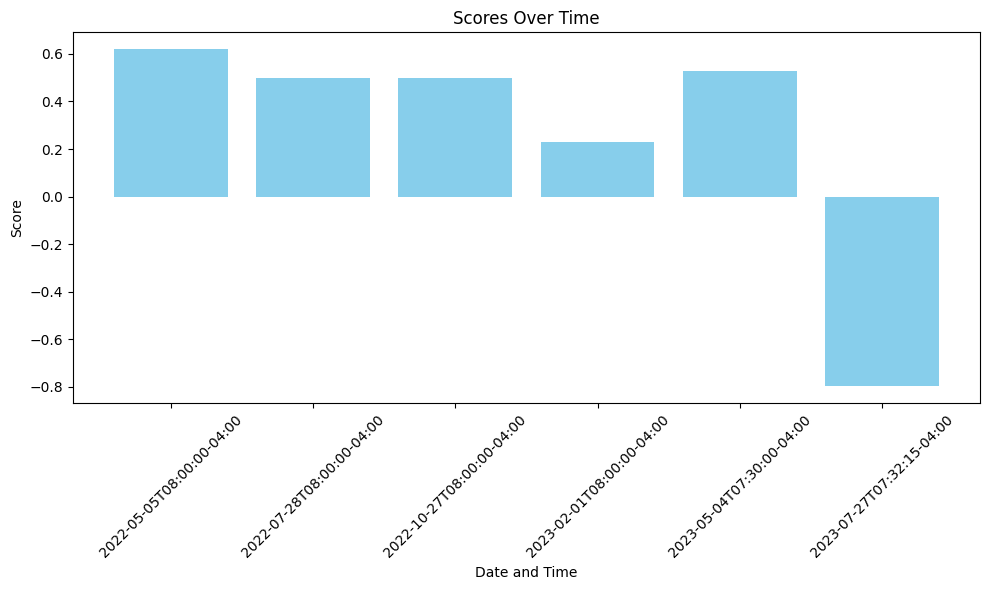

In [284]:
import matplotlib.pyplot as plt

# Create a bar plot for the 'Score' column
plt.figure(figsize=(10, 6))
plt.bar(Viklund_Sentiment_signals['Date_time'], Viklund_Sentiment_signals['Score'], color='skyblue')
plt.xlabel('Date and Time')
plt.ylabel('Score')
plt.title('Scores Over Time')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

C:\Users\benjo\AppData\Local\Temp\ipykernel_3604\2708491610.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust the rect parameter as needed


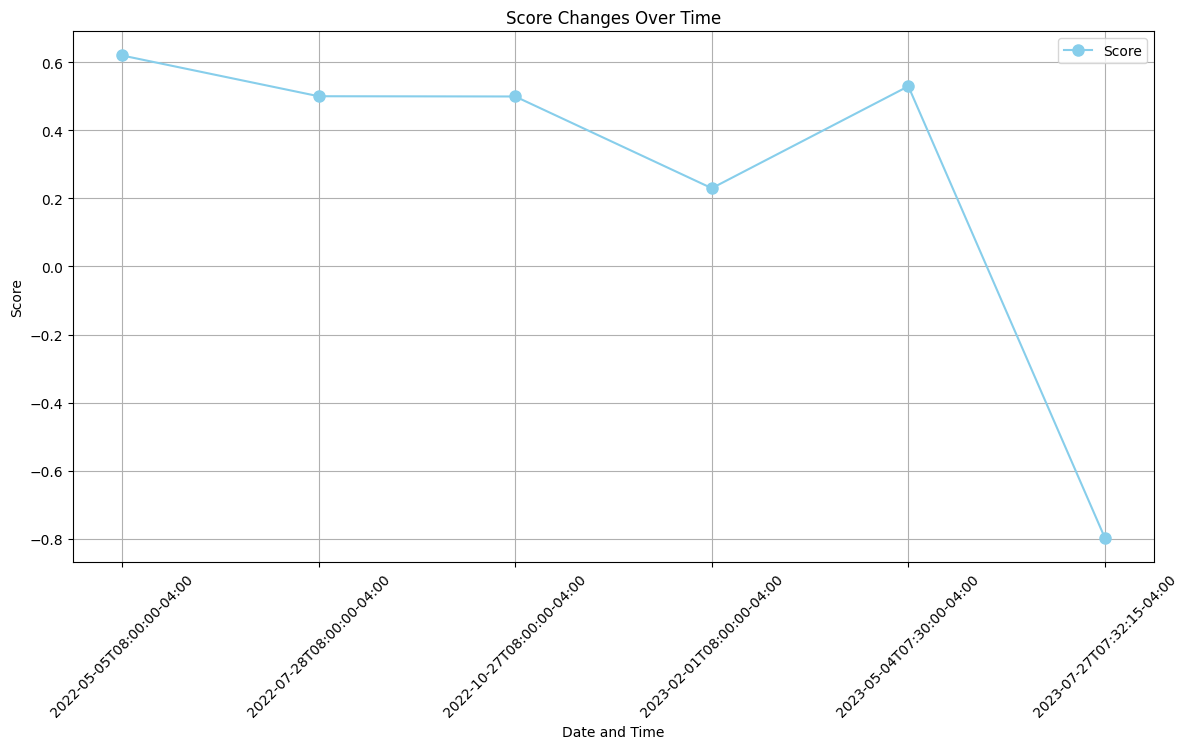

In [329]:
# Create a line plot for the 'Score' column
plt.figure(figsize=(12, 8))  # Increase the figure size
plt.plot(Viklund_Sentiment_signals['Date_time'], Viklund_Sentiment_signals['Score'], marker='o', color='skyblue', linestyle='-', markersize=8, label='Score')
plt.xlabel('Date and Time')
plt.ylabel('Score')
plt.title('Score Changes Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.xticks(rotation=45)

# Increase padding around the plot
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust the rect parameter as needed


# Save the plot to a file (e.g., PNG format)
plt.savefig('score_change_overt_time_plot.png')
plt.show()

Comparison

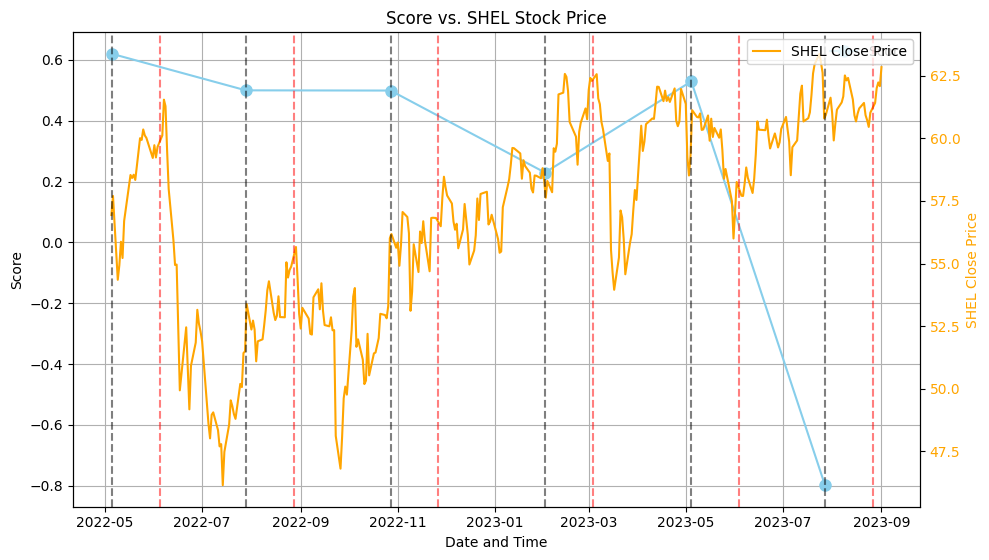

In [330]:
import yfinance as yf
from datetime import timedelta
Viklund_Sentiment_signals['Date_time'] = pd.to_datetime(Viklund_Sentiment_signals['Date_time'])
# Define the company's ticker symbol (e.g., Apple Inc.)
ticker_symbol = "SHEL"

# Fetch historical stock data from Yahoo Finance for the date range of your scores data
start_date = Viklund_Sentiment_signals['Date_time'].min().date()
end_date = Viklund_Sentiment_signals['Date_time'].max().date() + timedelta(days=40)
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)

# Reset the index of the stock data to use Date as a column
stock_data.reset_index(inplace=True)

# Create a line plot for the 'Score' column
plt.figure(figsize=(10, 6))
plt.plot(Viklund_Sentiment_signals['Date_time'], Viklund_Sentiment_signals['Score'], marker='o', color='skyblue', linestyle='-', markersize=8, label='Score')
plt.xlabel('Date and Time')
plt.ylabel('Score')
plt.title(f'Score vs. {ticker_symbol} Stock Price')
plt.legend()
plt.grid(True)

# Create a second y-axis for the stock price
ax2 = plt.twinx()
ax2.plot(stock_data['Date'], stock_data['Close'], color='orange', linestyle='-', label=f'{ticker_symbol} Close Price')
ax2.set_ylabel(f'{ticker_symbol} Close Price', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

# Draw vertical lines at the x-locations of the scores
for score_date in Viklund_Sentiment_signals['Date_time']:
    plt.axvline(x=score_date, color='black', linestyle='--', alpha=0.5)
    # Calculate the date 30 days later
    thirty_days_later = score_date + timedelta(days=30)
    plt.axvline(x=thirty_days_later, color='red', linestyle='--', alpha=0.5)


# Display the plot
plt.xticks(rotation=45)
# Increase padding around the plot
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust the rect parameter as needed

# Save the plot to a file (e.g., PNG format)
plt.savefig('score_vs_shel_stock_price_plot.png')

plt.show()

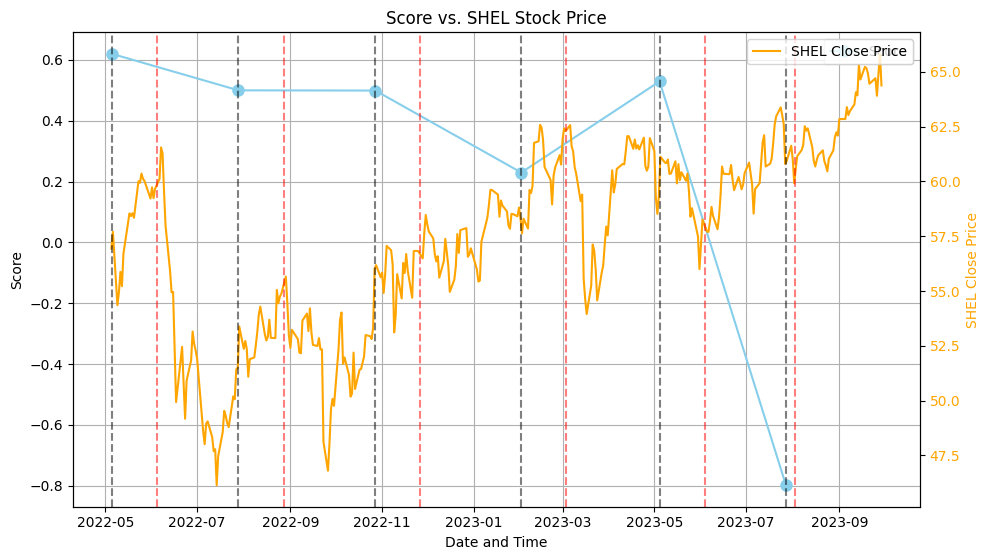

In [331]:
import yfinance as yf
from datetime import timedelta
Viklund_Sentiment_signals['Date_time'] = pd.to_datetime(Viklund_Sentiment_signals['Date_time'])
# Define the company's ticker symbol (e.g., Apple Inc.)
ticker_symbol = "SHEL"

# Fetch historical stock data from Yahoo Finance for the date range of your scores data
start_date = Viklund_Sentiment_signals['Date_time'].min().date()
end_date = Viklund_Sentiment_signals['Date_time'].max().date() + timedelta(days=70)
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)

# Reset the index of the stock data to use Date as a column
stock_data.reset_index(inplace=True)

# Create a line plot for the 'Score' column
plt.figure(figsize=(10, 6))
plt.plot(Viklund_Sentiment_signals['Date_time'], Viklund_Sentiment_signals['Score'], marker='o', color='skyblue', linestyle='-', markersize=8, label='Score')
plt.xlabel('Date and Time')
plt.ylabel('Score')
plt.title(f'Score vs. {ticker_symbol} Stock Price')
plt.legend()
plt.grid(True)

# Create a second y-axis for the stock price
ax2 = plt.twinx()
ax2.plot(stock_data['Date'], stock_data['Close'], color='orange', linestyle='-', label=f'{ticker_symbol} Close Price')
ax2.set_ylabel(f'{ticker_symbol} Close Price', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

# Draw vertical lines at the x-locations of the scores
for index, score_date in enumerate(Viklund_Sentiment_signals['Date_time']):
    plt.axvline(x=score_date, color='black', linestyle='--', alpha=0.5)
    if Viklund_Sentiment_signals['Score'][index] < 0:
        num = 0.2*30
        # Calculate the date 30 days later
        thirty_days_later = score_date + timedelta(days=num)
        plt.axvline(x=thirty_days_later, color='red', linestyle='--', alpha=0.5)
    elif Viklund_Sentiment_signals['Score'][index] > 0:
        num = 30
        # Calculate the date 30 days later
        thirty_days_later = score_date + timedelta(days=num)
        plt.axvline(x=thirty_days_later, color='red', linestyle='--', alpha=0.5)
        
    


# Display the plot
plt.xticks(rotation=45)

# Increase padding around the plot
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust the rect parameter as needed

# Save the plot to a file (e.g., PNG format)
plt.savefig('score_vs_shel_stock_price_plot.png')
plt.show()

## BP

In [62]:
BP_Viklund_Sentiment_signals = pd.DataFrame({
    "Date_time" : [max(bp_q1_2022['Date']),max(bp_q2_2022['Date']), max(bp_q3_2022['Date']), max(bp_q4_2022['Date']), max(bp_q1_2023['Date'])], 
    "Sentiment" : [bp_q1_2022_results[0], bp_q2_2022_results[0], bp_q3_2022_results[0], bp_q4_2022_results[0],bp_q1_2023_results[0]],
    "Score" : [bp_q1_2022_results[1], bp_q2_2022_results[1], bp_q3_2022_results[1], bp_q4_2022_results[1], bp_q1_2023_results[1]],
    "Sentiment_ID" : [bp_q1_2022_results[2], bp_q2_2022_results[2], bp_q3_2022_results[2], bp_q4_2022_results[2], bp_q1_2023_results[2]],
    "Quarter" : [1, 2, 3, 4, 1]
}) 


BP_Viklund_Sentiment_signals

,Date_time,Sentiment,Score,Sentiment_ID,Quarter
0,2022-05-03T11:31:03-04:00,POSITIVE,0.524051,2,1
1,2022-08-02T15:57:00-04:00,POSITIVE,0.470639,2,2
2,2022-11-01T13:12:00-05:00,POSITIVE,0.259945,2,3
3,2023-02-07T12:53:00-05:00,POSITIVE,0.304934,2,4
4,2023-05-02T12:05:00-04:00,POSITIVE,0.475735,2,1


In [63]:
BP_Viklund_Sentiment_signals.to_csv('bp_Viklund_Sentiment_signals.csv', index=False)

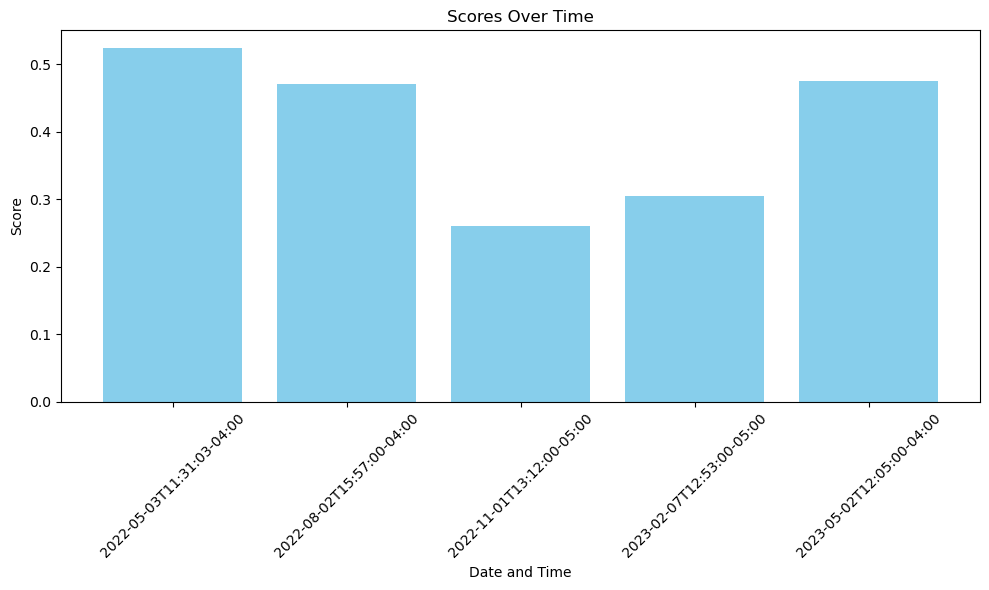

In [64]:
# Create a bar plot for the 'Score' column
plt.figure(figsize=(10, 6))
plt.bar(BP_Viklund_Sentiment_signals['Date_time'], BP_Viklund_Sentiment_signals['Score'], color='skyblue')
plt.xlabel('Date and Time')
plt.ylabel('Score')
plt.title('Scores Over Time')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

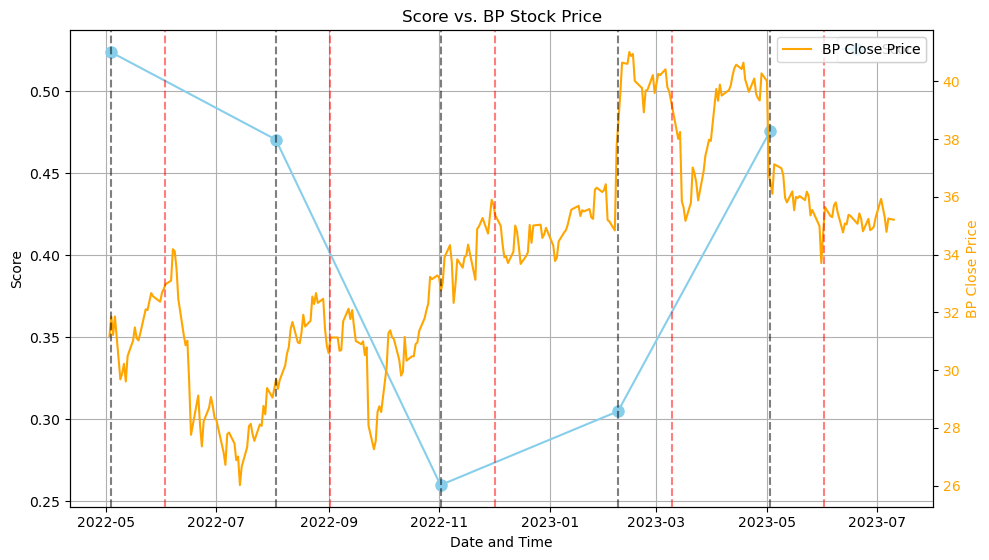

In [89]:
import yfinance as yf
from datetime import timedelta
# BP_Viklund_Sentiment_signals['Date_time'] = pd.to_datetime(BP_Viklund_Sentiment_signals['Date_time'])
# Define the company's ticker symbol (e.g., Apple Inc.)
ticker_symbol = "BP"

# Fetch historical stock data from Yahoo Finance for the date range of your scores data
start_date = BP_Viklund_Sentiment_signals['Date_time'].min().date()
end_date = BP_Viklund_Sentiment_signals['Date_time'].max().date() + timedelta(days=70)
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)

# Reset the index of the stock data to use Date as a column
stock_data.reset_index(inplace=True)

# Create a line plot for the 'Score' column
plt.figure(figsize=(10, 6))
plt.plot(BP_Viklund_Sentiment_signals['Date_time'], BP_Viklund_Sentiment_signals['Score'], marker='o', color='skyblue', linestyle='-', markersize=8, label='Score')
plt.xlabel('Date and Time')
plt.ylabel('Score')
plt.title(f'Score vs. {ticker_symbol} Stock Price')
plt.legend(loc='upper right')
plt.grid(True)

# Create a second y-axis for the stock price
ax2 = plt.twinx()
ax2.plot(stock_data['Date'], stock_data['Close'], color='orange', linestyle='-', label=f'{ticker_symbol} Close Price')
ax2.set_ylabel(f'{ticker_symbol} Close Price', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')


# Draw vertical lines at the x-locations of the scores
for index, score_date in enumerate(BP_Viklund_Sentiment_signals['Date_time']):
    plt.axvline(x=score_date, color='black', linestyle='--', alpha=0.5)
    if BP_Viklund_Sentiment_signals['Score'][index] < 0:
        num = 0.2*30
        # Calculate the date 30 days later
        thirty_days_later = score_date + timedelta(days=num)
        plt.axvline(x=thirty_days_later, color='red', linestyle='--', alpha=0.5)
    elif BP_Viklund_Sentiment_signals['Score'][index] > 0:
        num = 30
        # Calculate the date 30 days later
        thirty_days_later = score_date + timedelta(days=num)
        plt.axvline(x=thirty_days_later, color='red', linestyle='--', alpha=0.5)
        
    


# Display the plot
plt.xticks(rotation=45)

# Increase padding around the plot
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust the rect parameter as needed
# plt.legend()
# Save the plot to a file (e.g., PNG format)
plt.savefig('score_vs_bp_stock_price_plot.png')
plt.show()